In [338]:
# import the required libraries
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2
import torch
import math

In [339]:
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')

In [340]:
key_pts_frame = pd.read_csv('./data/training_frames_keypoints.csv')
a = key_pts = key_pts_frame.iloc[:, 1:].to_numpy()
kp_std = np.std(a)
kp_mean = np.mean(a)
print(f"Mean of keypoint: {kp_mean}")
print(f"STD of keypoint: {kp_std}")

Mean of keypoint: 104.4724870017331
STD of keypoint: 43.173022717543226


In [483]:
from torch.utils.data import Dataset, DataLoader

class FacialKeypointsDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.key_pts_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.key_pts_frame)

    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir,
                                self.key_pts_frame.iloc[idx, 0])
        
        image = mpimg.imread(image_name)
        
        # if image has an alpha color channel, get rid of it
        if(image.shape[2] == 4):
            image = image[:,:,0:3]
        
        key_pts = self.key_pts_frame.iloc[idx, 1:].to_numpy()
        key_pts = key_pts.astype('float').reshape(-1, 2)
        sample = {'image': image, 'keypoints': key_pts}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [535]:
# Construct the dataset
face_dataset = FacialKeypointsDataset(csv_file='./data/training_frames_keypoints.csv',
                                      root_dir='./data/training/')

# print some stats about the dataset
print('Length of dataset: ', len(face_dataset))

Length of dataset:  3462


0 (358, 357, 3) (68, 2)
1 (175, 141, 3) (68, 2)
2 (210, 213, 3) (68, 2)


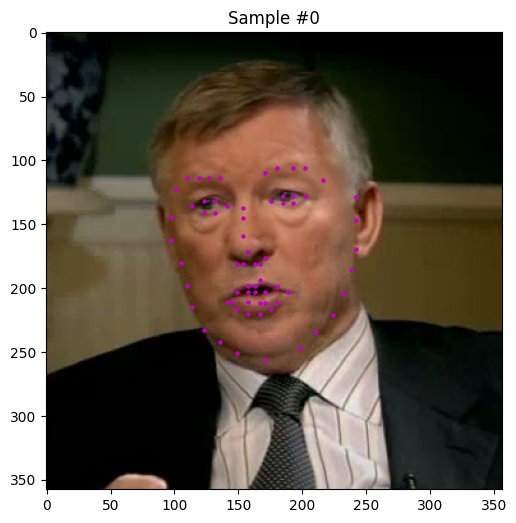

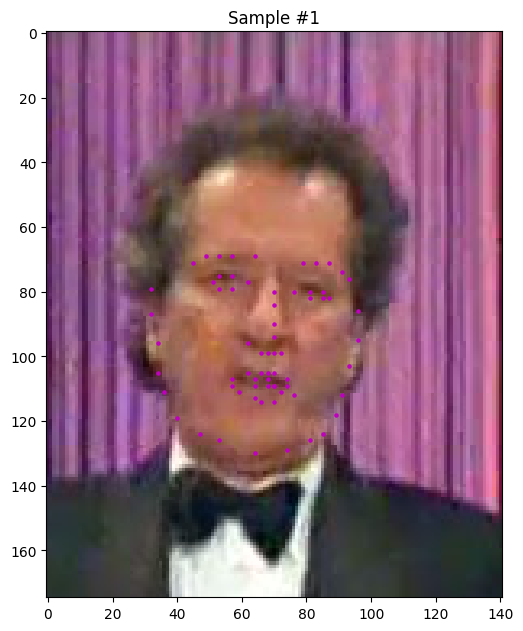

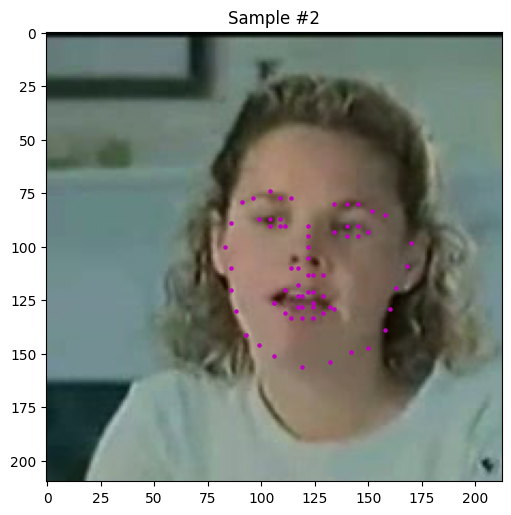

In [536]:
# Display a few of the images from the dataset
num_to_display = 3

for i in range(num_to_display):
    
    # define the size of images
    fig = plt.figure(figsize=(20,10))
    
    # randomly select a sample
    rand_i = np.random.randint(0, len(face_dataset))
    sample = face_dataset[rand_i]

    # print the shape of the image and keypoints
    print(i, sample['image'].shape, sample['keypoints'].shape)

    ax = plt.subplot(1, num_to_display, i + 1)
    ax.set_title('Sample #{}'.format(i))
    
    # Using the same display function, defined earlier
    show_keypoints(sample['image'], sample['keypoints'])

In [537]:
import torch
from torchvision import transforms, utils
# tranforms

class Normalize(object):
    """Convert a color image to grayscale and normalize the color range to [0,1]."""        

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        
        key_pts_copy = np.copy(key_pts)

        key_pts_copy = (key_pts_copy - 100)/50.0


        return {'image': image, 'keypoints': key_pts_copy}


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(image, (new_w, new_h))
        
        # scale the pts, too
        key_pts = key_pts * [new_w / w, new_h / h]

        return {'image': img, 'keypoints': key_pts}


class RandomRotation(object):
    
    def __init__(self, angle: int, p=0.5):
        super().__init__()
        if not (isinstance(p, float) and (0.0 <= p <= 1.0)):
            raise ValueError("probability should be float between 0 and 1")
        self.p = p
        self.angle = angle

    def __call__(self, sample):
        if torch.rand(1) < self.p:
            angle = np.random.randint(-self.angle, self.angle)
            image, key_pts = sample['image'], sample['keypoints']

            height, width = image.shape[:2]

            # Calculate the rotation matrix
            rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1)
            rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height), flags=cv2.INTER_LINEAR)

            key_pts_homo = np.hstack((key_pts, np.ones((key_pts.shape[0], 1))))
            key_pts_homo_rot = np.dot(rotation_matrix, key_pts_homo.T).T
            key_pts_rot = key_pts_homo_rot[:, :2]

            return {'image': rotated_image, 'keypoints': key_pts_rot}

        return sample
    
class RandomTranslation(object):
    def __init__(self, translate: (float, float), p=0.5):
        """

        :type translate: (float, float) x, y translate in percent - from 0 to 1
        """
        super().__init__()
        if not (isinstance(p, float) and (0.0 <= p <= 1.0)):
            raise ValueError("probability should be float between 0 and 1")
        if not (len(translate) == 2 and (0.0 <= translate[0] <= 1.0) and (0.0 <= translate[1] <= 1.0)):
            raise ValueError("there should be 2 numbers in translate, both between 0 and 1")
        self.p = p
        self.translate = translate

    def __call__(self, sample):
        if torch.rand(1) < self.p:
            image, key_pts = sample['image'], sample['keypoints']

            height, width = image.shape[0], image.shape[1]

            x_translate_rate = np.random.uniform(low=-self.translate[0], high=self.translate[0])
            y_translate_rate = np.random.uniform(low=-self.translate[1], high=self.translate[1])
            x_translate_pixel = width * x_translate_rate
            y_translate_pixel = height * y_translate_rate

            # Image translation
            M = np.float32([[1, 0, x_translate_pixel], [0, 1, y_translate_pixel]])
            shifted = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))

            # Keypoints translation
            key_pts = key_pts + np.array([x_translate_pixel, y_translate_pixel])

            return {'image': shifted, 'keypoints': key_pts}

        return sample
    
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        key_pts = key_pts - [left, top]

        return {'image': image, 'keypoints': key_pts}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
         
        # if image has no grayscale color channel, add one
        if(len(image.shape) == 2):
            # add that third color dim
            image = image.reshape(image.shape[0], image.shape[1], 1)
            
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'keypoints': torch.from_numpy(key_pts)}

(113, 100, 3)
(174, 153, 3)
(174, 153, 3)
(174, 153, 3)


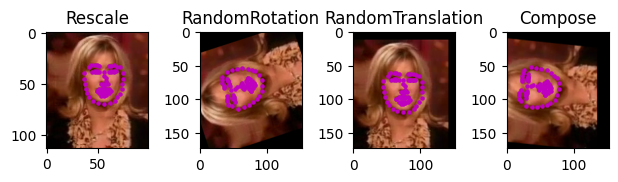

In [538]:
rescale = Rescale(100)
rotate = RandomRotation(180, 1.0)
translate = RandomTranslation((0.2,0.2), 1.0)
composed = transforms.Compose([RandomRotation(180, 1.0), RandomTranslation((0.2,0.2), 1.0)])

# apply the transforms to a sample image
test_num = 500
sample = face_dataset[test_num]

fig = plt.figure()
for i, tx in enumerate([rescale, rotate, translate, composed]):
    transformed_sample = tx(sample)
    
    print(transformed_sample['image'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title(type(tx).__name__)
    show_keypoints(transformed_sample['image'], transformed_sample['keypoints'])

plt.show()

In [539]:
# define the data tranform
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     RandomRotation(45, 0.5),
                                     RandomTranslation((0.2,0.2), 0.5),
                                     Normalize(),
                                     ToTensor()])

# create the transformed dataset
train_dataset = FacialKeypointsDataset(csv_file='./data/training_frames_keypoints.csv',
                                             root_dir='./data/training/',
                                             transform=data_transform)
test_dataset = FacialKeypointsDataset(csv_file='./data/test_frames_keypoints.csv',
                                             root_dir='./data/test/',
                                             transform=data_transform)

In [540]:
# ## Define the Net in models.py

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torchvision

# ## Once you've define the network, you can instantiate it
# # one example conv layer has been provided for you
# from model import Net

# net = Net().to('cuda')
# print(net)

In [541]:
model = torchvision.models.resnet18(pretrained=True)

model.fc = torch.nn.Linear(model.fc.in_features, 68*2)

model = model.type(torch.FloatTensor)
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
net = model.to(device)

/home/davidyao99/miniconda3/envs/image_morph/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/davidyao99/miniconda3/envs/image_morph/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [542]:
# load training data in batches
batch_size = 16

train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)
test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

In [543]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor).to(device)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images.cpu(), output_pts.cpu(), key_pts

In [544]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    
    # image is grayscale
    plt.imshow(image)
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

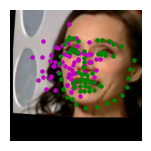

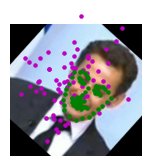

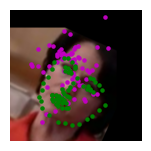

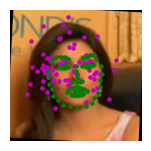

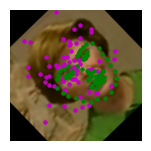

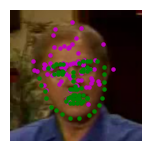

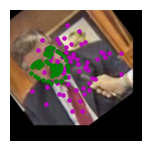

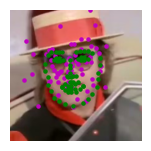

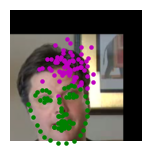

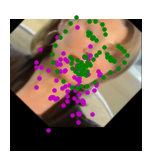

In [545]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image
        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
test_images, test_outputs, gt_pts = net_sample_output()
visualize_output(test_images, test_outputs, gt_pts)

In [546]:
## Define the loss and optimization
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001)

In [547]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()
    training_loss = []

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor).to('cuda')
            images = images.type(torch.FloatTensor).to('cuda')

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0
        training_loss.append(running_loss)
        del images
        del key_pts
        torch.cuda.empty_cache()

    print('Finished Training')
    return training_loss

In [548]:
# train your network
n_epochs = 4 # start small, and increase when you've decided on your model structure and hyperparams

training_loss = train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.5278303787112236
Epoch: 1, Batch: 20, Avg. Loss: 0.17429141849279403
Epoch: 1, Batch: 30, Avg. Loss: 0.12524812817573547
Epoch: 1, Batch: 40, Avg. Loss: 0.11725825071334839
Epoch: 1, Batch: 50, Avg. Loss: 0.12719600200653075
Epoch: 1, Batch: 60, Avg. Loss: 0.14937116391956806
Epoch: 1, Batch: 70, Avg. Loss: 0.09390962831676006
Epoch: 1, Batch: 80, Avg. Loss: 0.07180342301726342
Epoch: 1, Batch: 90, Avg. Loss: 0.06961271949112416
Epoch: 1, Batch: 100, Avg. Loss: 0.23224020674824714
Epoch: 1, Batch: 110, Avg. Loss: 0.08889182470738888
Epoch: 1, Batch: 120, Avg. Loss: 0.07681938223540782
Epoch: 1, Batch: 130, Avg. Loss: 0.09708279967308045
Epoch: 1, Batch: 140, Avg. Loss: 0.12360582984983921
Epoch: 1, Batch: 150, Avg. Loss: 0.10377193018794059
Epoch: 1, Batch: 160, Avg. Loss: 0.10338501147925853
Epoch: 1, Batch: 170, Avg. Loss: 0.09925954900681973
Epoch: 1, Batch: 180, Avg. Loss: 0.06381477303802967
Epoch: 1, Batch: 190, Avg. Loss: 0.0507361451163888
Epoc

KeyboardInterrupt: 

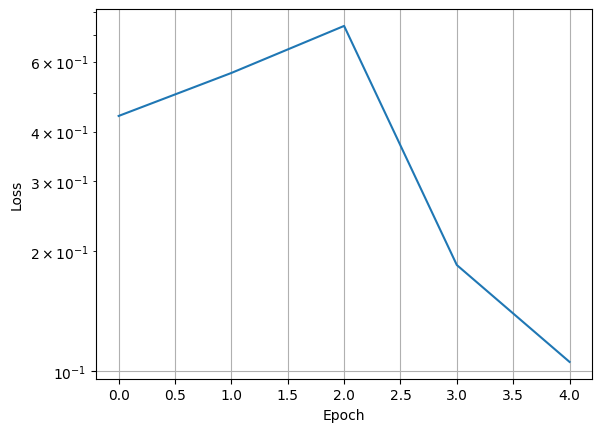

In [549]:
# visualize the loss as the network trained
plt.figure()
plt.semilogy(training_loss)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss');

In [550]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([16, 3, 224, 224])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])


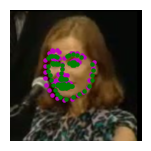

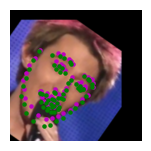

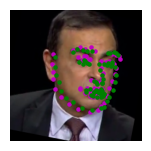

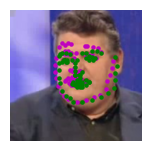

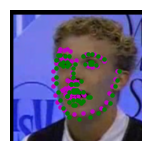

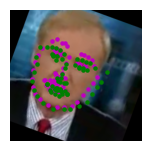

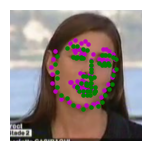

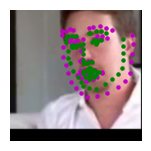

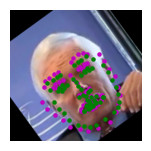

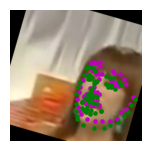

In [551]:
## visualize  test output
# you can use the same function as before, by un-commenting the line below:
visualize_output(test_images, test_outputs, gt_pts)

In [552]:
## change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'resnet18_pretrain_model.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

In [553]:
model = torchvision.models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, 68*2)
model = model.type(torch.FloatTensor)
net = model.to('cuda')
net.load_state_dict(torch.load('saved_models/resnet18_pretrain_model.pt'))

<All keys matched successfully>